In [1]:
import numpy as np
import os
import tensorflow as tf
import shutil
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [2]:
"""def create_sorted_directories(base_dir):
    # Define the categories and their corresponding directories
    categories = ['Normal', 'Virus', 'Bacteria']
    for category in categories:
        category_dir = os.path.join(base_dir, category)
        os.makedirs(category_dir, exist_ok=True)

def sort_and_cleanup_images(base_dir):
    # Create target directories
    create_sorted_directories(base_dir)

    # Define paths to category directories
    normal_dir = os.path.join(base_dir, 'Normal')
    virus_dir = os.path.join(base_dir, 'Virus')
    bacteria_dir = os.path.join(base_dir, 'Bacteria')

    # Iterate over all files in the directory
    for subdir, dirs, files in os.walk(base_dir):
        for file in files:
            # Skip if we are in the already sorted directories
            if subdir in [normal_dir, virus_dir, bacteria_dir]:
              continue

            # Move file based on its name
            if 'pneumonia' in file.lower():
                shutil.move(os.path.join(subdir, file), os.path.join(bacteria_dir, file))
            elif 'covid' in file.lower():
                shutil.move(os.path.join(subdir, file), os.path.join(virus_dir, file))
            elif 'normal' in file.lower():
                shutil.move(os.path.join(subdir, file), os.path.join(normal_dir, file))

        # If the directory is empty, delete it
        if not os.listdir(subdir):
            shutil.rmtree(subdir, ignore_errors=True)

# Specify your train and test directories
train_dir = '/content/drive/MyDrive/Data/train'
test_dir = '/content/drive/MyDrive/Data/test'

# Run the sorting and cleanup function for both train and test directories
sort_and_cleanup_images(train_dir)
sort_and_cleanup_images(test_dir)"""


"def create_sorted_directories(base_dir):\n    # Define the categories and their corresponding directories\n    categories = ['Normal', 'Virus', 'Bacteria']\n    for category in categories:\n        category_dir = os.path.join(base_dir, category)\n        os.makedirs(category_dir, exist_ok=True)\n\ndef sort_and_cleanup_images(base_dir):\n    # Create target directories\n    create_sorted_directories(base_dir)\n\n    # Define paths to category directories\n    normal_dir = os.path.join(base_dir, 'Normal')\n    virus_dir = os.path.join(base_dir, 'Virus')\n    bacteria_dir = os.path.join(base_dir, 'Bacteria')\n\n    # Iterate over all files in the directory\n    for subdir, dirs, files in os.walk(base_dir):\n        for file in files:\n            # Skip if we are in the already sorted directories\n            if subdir in [normal_dir, virus_dir, bacteria_dir]:\n              continue\n\n            # Move file based on its name\n            if 'pneumonia' in file.lower():\n              

In [3]:
# Data Augmentation
train_idg = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range = 0.2,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

test_idg = ImageDataGenerator(
    rescale=1./255
)

In [4]:
# Data loading
train = train_idg.flow_from_directory(
    '/content/drive/MyDrive/Data/train',
    class_mode='categorical',
    color_mode="rgb",
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    seed=42
)

test = test_idg.flow_from_directory(
    '/content/drive/MyDrive/Data/test',
    class_mode='categorical',
    color_mode="rgb",
    target_size=(224, 224),
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 5174 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


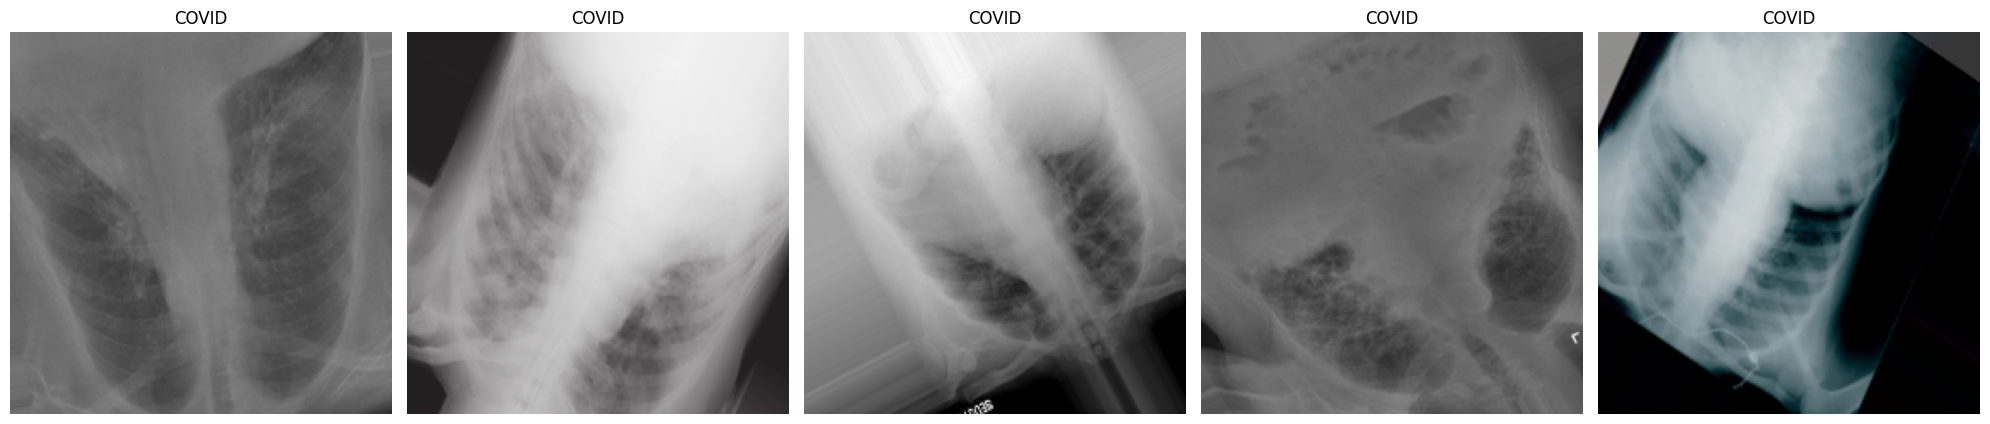

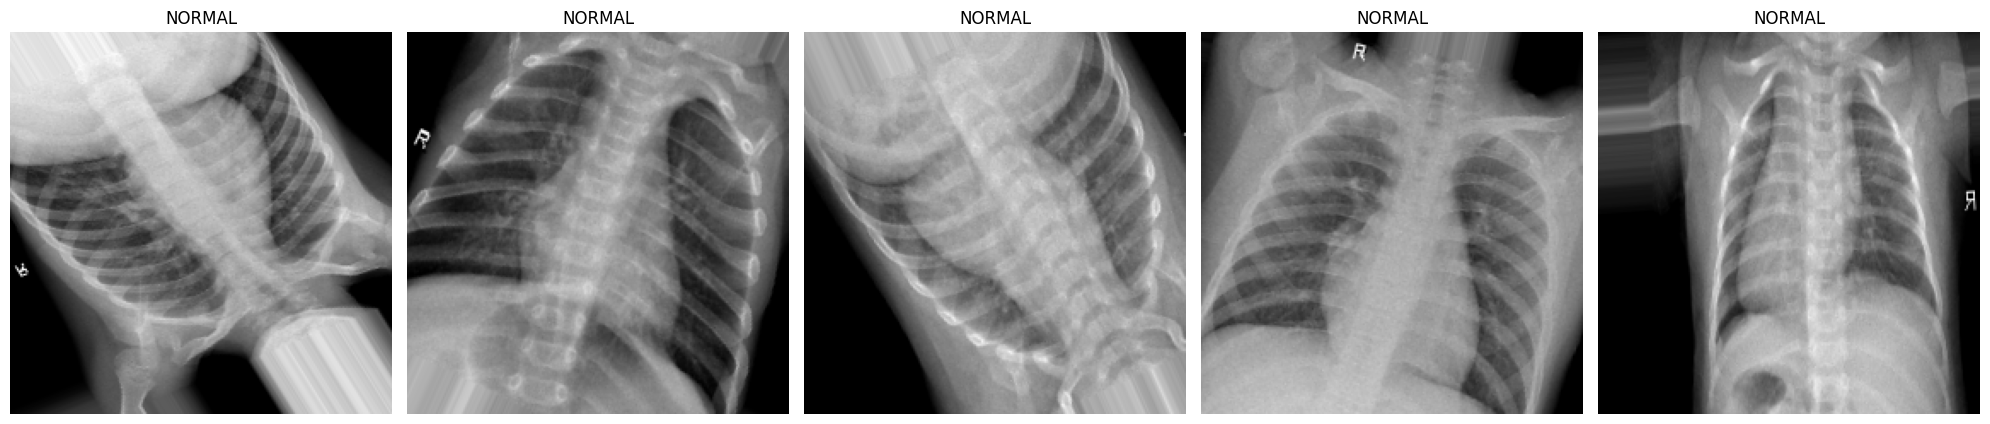

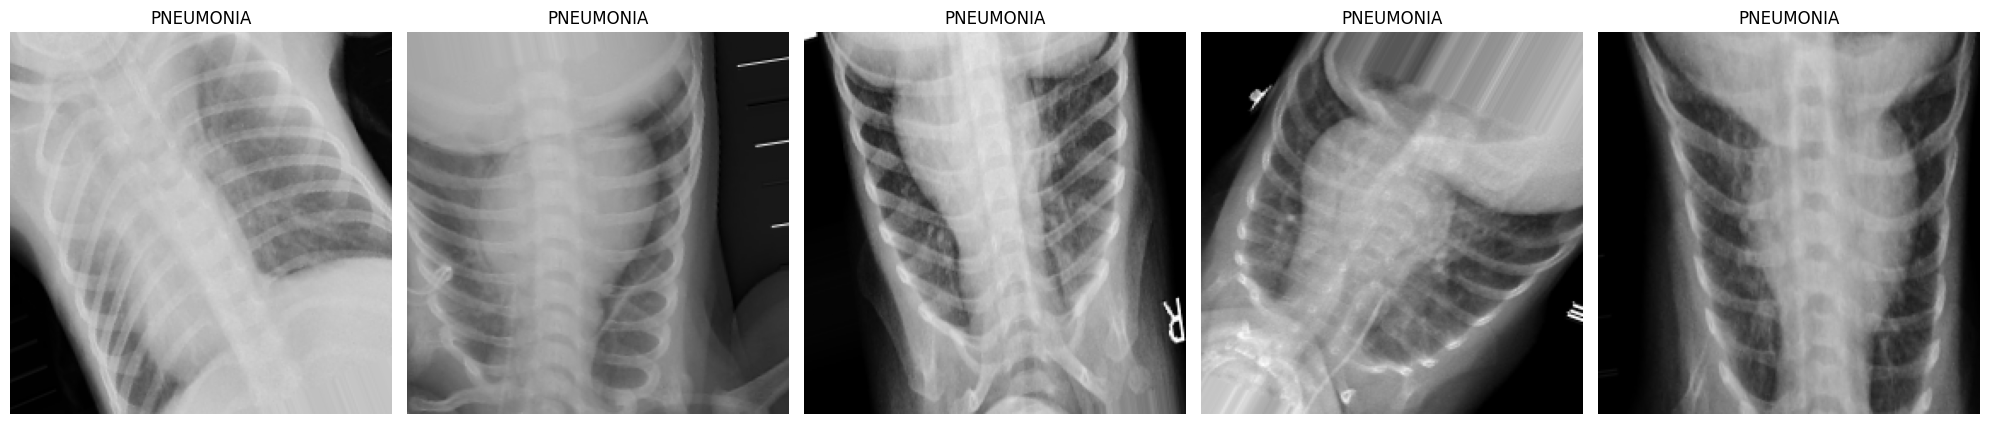

In [5]:
def plot_images(images_arr, labels_arr, class_labels):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, label, ax in zip(images_arr, labels_arr, axes):
        ax.imshow(img)
        # Setting the title for each image to its corresponding label
        ax.set_title(class_labels[label])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Fetch and plot a batch of images from the train generator
class_indices = {v: k for k, v in train.class_indices.items()}  # Reverse the class_indices dictionary

images_to_plot = {i: [] for i in range(3)}  # Dictionary to hold 5 images for each category

# Loop until we collect 5 images for each category
while any(len(images) < 5 for images in images_to_plot.values()):
    images, labels = next(train)
    for i in range(3):  # There are three categories
        if len(images_to_plot[i]) < 5:  
            # Filter images by class
            images_by_class = images[np.argmax(labels, axis=1) == i]
            labels_by_class = np.argmax(labels[np.argmax(labels, axis=1) == i], axis=1)
            
            images_to_plot[i].extend(images_by_class[:5 - len(images_to_plot[i])])

# Plot the collected images for each category
for i in range(3):
    plot_images(images_to_plot[i], [i] * len(images_to_plot[i]), class_indices)

In [6]:
# Load up pretrained model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [7]:
# Freeze layers of base model
for layer in base_model.layers[:144]:
  layer.trainable = False


In [8]:
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(3, activation='softmax')(x)

In [9]:
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=5,
                                            verbose=1,
                                            factor=0.3,
                                            min_lr=0.0001)

In [11]:
class_samples = {
    'Normal': len(os.listdir('/content/drive/MyDrive/Data/train/NORMAL')),
    'Virus': len(os.listdir('/content/drive/MyDrive/Data/train/COVID')),
    'Bacteria': len(os.listdir('/content/drive/MyDrive/Data/train/PNEUMONIA'))
}
# Total number of samples
total_samples = sum(class_samples.values())

# Class weights (inversely proportional to the class frequencies)
class_weights = {
    0: (1 / class_samples['Bacteria']) * (total_samples / 3.0),
    1: (1 / class_samples['Normal']) * (total_samples / 3.0),
    2: (1 / class_samples['Virus']) * (total_samples / 3.0),
}

In [12]:
# fit and train the model
history = model.fit(train,
                    validation_data=test,
                    epochs=40,
                    callbacks=[learning_rate_reduction],
                    class_weight=class_weights
)

Epoch 1/40
162/162 [==============================] - 1461s 9s/step - loss: 1.9466 - accuracy: 0.6001 - val_loss: 1.0549 - val_accuracy: 0.6638 - lr: 0.0010
Epoch 2/40
162/162 [==============================] - 179s 1s/step - loss: 1.0445 - accuracy: 0.7172 - val_loss: 1.2243 - val_accuracy: 0.6638 - lr: 0.0010
Epoch 3/40
162/162 [==============================] - 176s 1s/step - loss: 0.9143 - accuracy: 0.7292 - val_loss: 1.7659 - val_accuracy: 0.6638 - lr: 0.0010
Epoch 4/40
162/162 [==============================] - 177s 1s/step - loss: 0.8640 - accuracy: 0.7433 - val_loss: 1.2410 - val_accuracy: 0.2648 - lr: 0.0010
Epoch 5/40
162/162 [==============================] - 176s 1s/step - loss: 0.8162 - accuracy: 0.7524 - val_loss: 8.1062 - val_accuracy: 0.6638 - lr: 0.0010
Epoch 6/40
162/162 [==============================] - ETA: 0s - loss: 0.8023 - accuracy: 0.7528
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
162/162 [==============================] - 173s

In [13]:
# Save the model
model.save('resnet50_3_class_modelv4.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
# Evaluate the model
loss, accuracy = model.evaluate(test)
print("Loss of the model is - ", loss)
print("Accuracy of the model is - ", accuracy)

41/41 [==============================] - 23s 494ms/step - loss: 0.3451 - accuracy: 0.8517
Loss of the model is -  0.34510472416877747
Accuracy of the model is -  0.8517080545425415


In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Predictions and metrics
test.reset()
preds = model.predict(test, verbose=1)
predicted_classes = np.argmax(preds, axis=1)
true_classes = test.classes
class_labels = list(test.class_indices.keys())

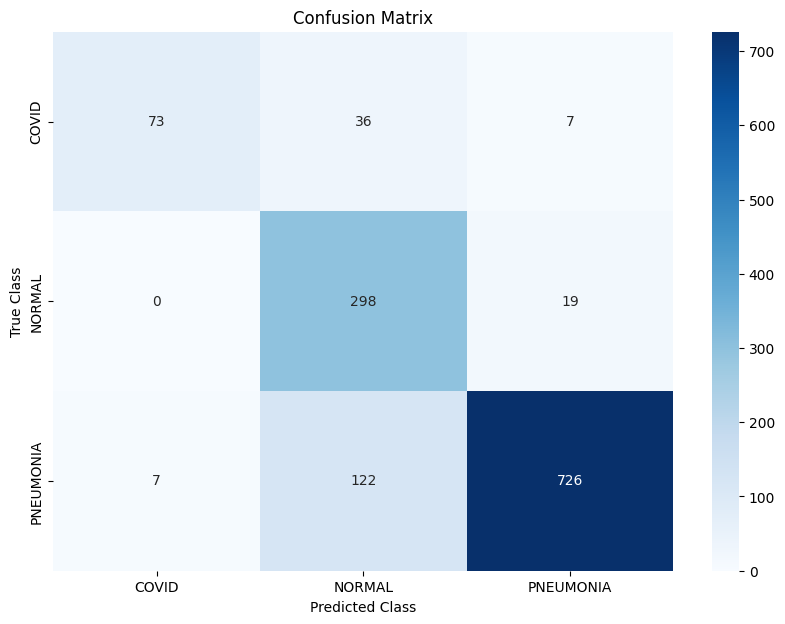

In [17]:
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [18]:
cr = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", cr)

Classification Report:
               precision    recall  f1-score   support

       COVID       0.91      0.63      0.74       116
      NORMAL       0.65      0.94      0.77       317
   PNEUMONIA       0.97      0.85      0.90       855

    accuracy                           0.85      1288
   macro avg       0.84      0.81      0.81      1288
weighted avg       0.88      0.85      0.86      1288

Classification Report:
               precision    recall  f1-score   support

       COVID       0.91      0.63      0.74       116
      NORMAL       0.65      0.94      0.77       317
   PNEUMONIA       0.97      0.85      0.90       855

    accuracy                           0.85      1288
   macro avg       0.84      0.81      0.81      1288
weighted avg       0.88      0.85      0.86      1288

